In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device using: {device}')

Device using: cuda


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 76% 52.0M/68.8M [00:00<00:00, 167MB/s] 
100% 68.8M/68.8M [00:00<00:00, 138MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fashionmnist.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [7]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


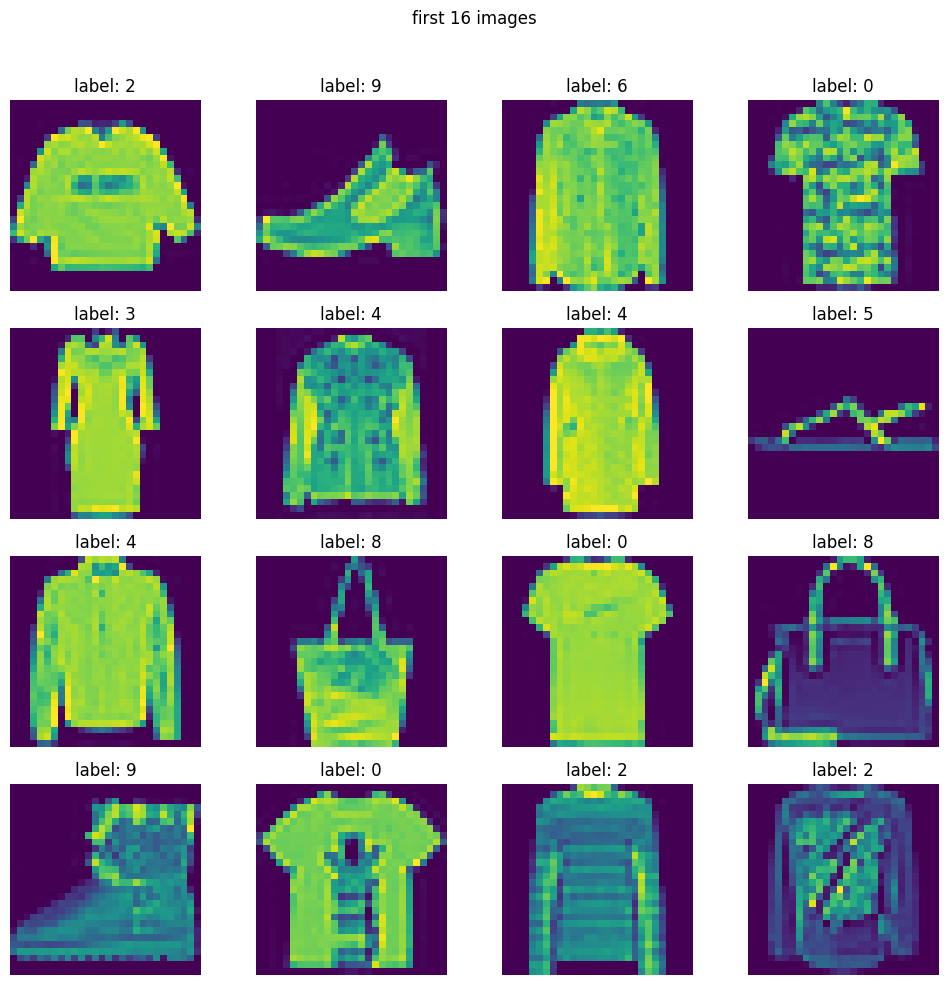

In [9]:
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle('first 16 images')

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f'label: {df.iloc[i, 0]}')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [24]:
df.shape

(60000, 785)

In [25]:
# train test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# scale the feature
X_train = X_train / 255.0
X_test = X_test / 255.0

In [40]:
# create custom dataset class
class customdataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [41]:
train_data = customdataset(X_train, y_train)
test_data = customdataset(X_test, y_test)

In [42]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, pin_memory=True)

In [58]:
class MyNN(nn.Module):

  def __init__(self, input_size):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 10))

  def forward(self, X):
    return self.model(X)

In [59]:
learning_rate = 0.1
epochs = 100

In [60]:
model = MyNN(X_train.shape[1])

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-7)

In [61]:
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    y_pred = model(batch_features)

    loss = criterion(y_pred, batch_labels)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    total_epoch_loss += loss.item()

  print(f'epoch: {epoch+1}, loss: {total_epoch_loss/len(train_loader)}')

epoch: 1, loss: 0.7221195515791575
epoch: 2, loss: 0.6040781202316284
epoch: 3, loss: 0.5798350714842478
epoch: 4, loss: 0.5587222632567088
epoch: 5, loss: 0.5343753448327382
epoch: 6, loss: 0.5286165957450867
epoch: 7, loss: 0.5040930909315745
epoch: 8, loss: 0.5089813954035441
epoch: 9, loss: 0.5000526260534922
epoch: 10, loss: 0.5028768994808197
epoch: 11, loss: 0.4935546685854594
epoch: 12, loss: 0.4947605051199595
epoch: 13, loss: 0.475457142273585
epoch: 14, loss: 0.4849247571627299
epoch: 15, loss: 0.47549671490987144
epoch: 16, loss: 0.4794653505086899
epoch: 17, loss: 0.4736982712348302
epoch: 18, loss: 0.4717968869606654
epoch: 19, loss: 0.46520572757720946
epoch: 20, loss: 0.4775673732360204
epoch: 21, loss: 0.473988365650177
epoch: 22, loss: 0.45637286198139193
epoch: 23, loss: 0.46698661188284557
epoch: 24, loss: 0.46390574089686076
epoch: 25, loss: 0.4804731305837631
epoch: 26, loss: 0.4685685397783915
epoch: 27, loss: 0.47007468831539156
epoch: 28, loss: 0.45580636998017

In [62]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [63]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    y_pred = model(batch_features)
    _, predicted = torch.max(y_pred.data, 1)
    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

print(correct/total)

0.8705


In [64]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    y_pred = model(batch_features)
    _, predicted = torch.max(y_pred.data, 1)
    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

print(correct/total)

0.8921666666666667
